In [8]:
import sys
if "/final-project/human-pose-estimation.pytorch-master/lib/" not in sys.path:
  sys.path.insert(0, "final-project/content/human-pose-estimation.pytorch-master/lib/")

In [9]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.transforms as T
from torchsummary import summary
import cv2
import re
import os
import copy
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import lib.models as models
from lib.core import * 
import lib.core.config as config
from lib.core.config import config
from lib.core.config import update_config
from lib.core.config import update_dir
from lib.core.config import get_model_name
from lib.core.config  import *

# Pretrained MPII ResNet50 Model

In [10]:
CONFIG_FILE = '/home/khadas/final-project/human-pose-estimation.pytorch-master/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
MODEL_PATH = '/home/khadas/final-project/human-pose-estimation.pytorch-master/model/pytorch/pose_mpii/pose_resnet_50_256x256.pth.tar'

In [11]:
model = eval('models.'+ config.MODEL.NAME+'.get_pose_net')(config, is_train=False)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

Input Image Transformation

In [12]:
transform = T.Compose([
                       T.Resize((256, 256)),
                       T.ToTensor(), 
                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])

# to tensor: convert numpy array or PIL image into a tensor format - the form of (C*H*W)
# normalize: take a tensor image and normalize it with mean and standard deviation

image = Image.open('/home/khadas/final-project/human-pose-estimation.pytorch-master/pics/squat.jpg')
tr_img = transform(image)

output = model(tr_img.unsqueeze(0))
output = output.squeeze(0)

_, OUT_HEIGHT, OUT_WIDTH = output.shape
print(f'output shape: {output.shape}')

# helper function we will use later
get_detached = lambda x: copy.deepcopy(x.cpu().detach().numpy())

POSE_PAIRS = [[9, 8],[8, 7],[7, 6],[6, 2],[2, 1],[1, 0],[6, 3],[3, 4],[4, 5],[7, 12],[12, 11],[11, 10],[7, 13],[13, 14],[14, 15]]

from operator import itemgetter
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_layer) for pose_layer in pose_layers])

JOINTS = ['0 - r ankle', '1 - r knee', '2 - r hip', '3 - l hip', '4 - l knee', '5 - l ankle', '6 - pelvis', '7 - thorax', '8 - upper neck', '9 - head top', '10 - r wrist', '11 - r elbow', '12 - r shoulder', '13 - l shoulder', '14 - l elbow', '15 - l wrist']
JOINTS = [re.sub(r'[0-9]+|-', '', joint).strip().replace(' ', '-') for joint in JOINTS]

output shape: torch.Size([16, 64, 64])


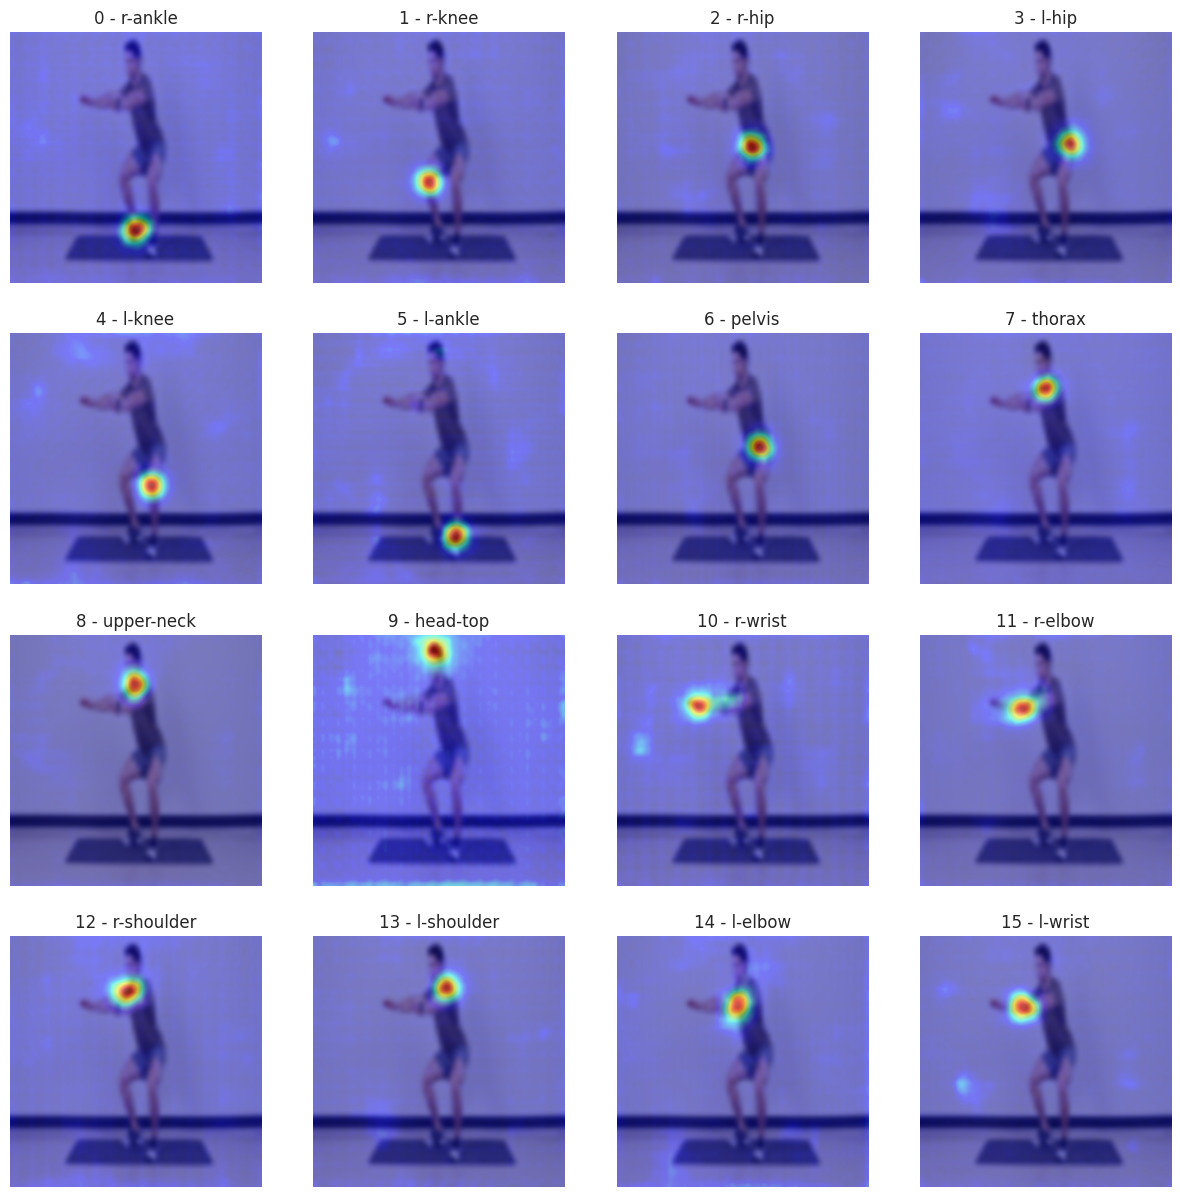

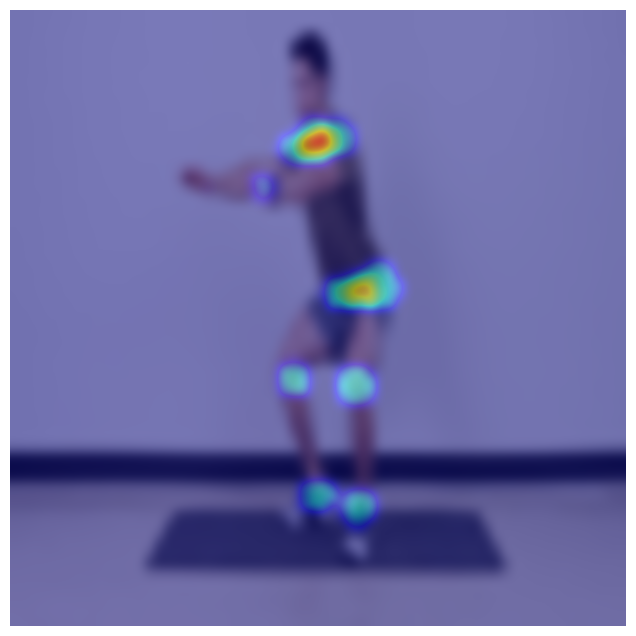

In [13]:
plt.figure(figsize=(15, 15))
for idx, pose_layer in enumerate(get_detached(output)):
    # print(pose_layer.shape)
    plt.subplot(4, 4, idx + 1)
    plt.title(f'{idx} - {JOINTS[idx]}')
    plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
    plt.imshow(pose_layer, alpha=0.5, cmap='jet', interpolation='bicubic')
    plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
pose_layers = get_detached(output)
pose_layers = np.clip(pose_layers, 0.7, 1.0)
layer_sum = np.sum(pose_layers, axis=0)
plt.imshow(layer_sum, alpha=0.5, cmap='jet', interpolation='bicubic')
plt.axis('off')
plt.show()

In [14]:
img_src = cv2.imread('/home/khadas/final-project/human-pose-estimation.pytorch-master/pics/squat.jpg',0)
print(img_src)

[[229 229 229 ... 225 225 225]
 [229 229 229 ... 225 225 225]
 [229 229 229 ... 225 225 225]
 ...
 [218 217 217 ... 217 219 220]
 [224 223 221 ... 215 215 215]
 [224 223 221 ... 215 215 215]]


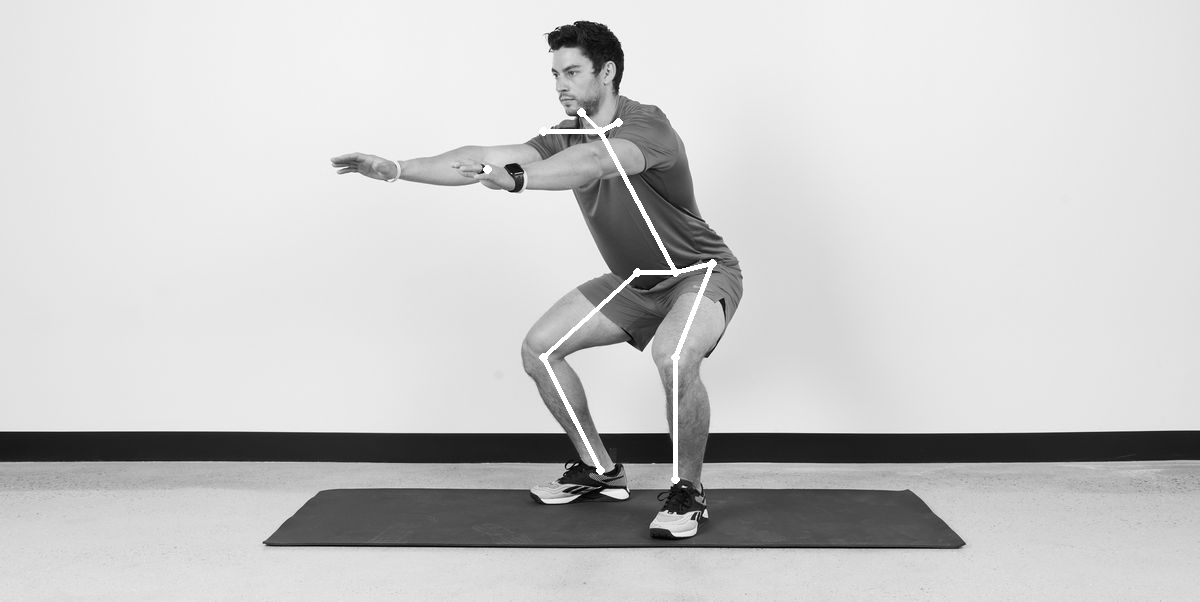

In [15]:
THRESHOLD = 0.8
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = img_src
pose_layers = get_detached(x=output)
key_points = list(get_keypoints(pose_layers=pose_layers))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)
        
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_GRAY2RGB))


Model Summary

In [16]:
# Model summary of the original input image
# summary(model, (3, 602, 1200))

In [17]:
# Model summary of the resized input image
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

# ONNX Model Optimization

The optimization uses ONNX Runtime native library to rewrite the computation graph, including merging computation nodes, eliminating redundancies to improve runtime efficiency.

ONNX is selected because of the limitation of PyTorch quantization - only a few models can be quantized such as LSTM, BERT, or else, further modifications have to be done

In [18]:
import io
import numpy as np
import torch.onnx
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType
import psutil
import onnxruntime
import time

In [19]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def print_size_of_onnx_model(model):
    onnx.save(model, 'temp.onnx')
    print('Size (MB):', os.path.getsize("temp.onnx")/1e6)
    os.remove('temp.onnx')

In [20]:
# current model size
print_size_of_model(model)

Size (MB): 136.303329


PyTorch to ONNX Model Conversion

In [21]:
# Input to the model
torch_model = model
batch_size = 1
x = torch.randn(1, 3, 256, 256, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "/home/khadas/final-project/human-pose-estimation.pytorch-master/output/human_pose_estimation.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

import onnx

onnx_model = onnx.load("/home/khadas/final-project/human-pose-estimation.pytorch-master/output/human_pose_estimation.onnx")
onnx.checker.check_model(onnx_model)

print_size_of_onnx_model(onnx_model)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Size (MB): 135.924938


Choose dynamic quantization with default settings and weight type of QUInt8

In [22]:
curr_model = '/home/khadas/final-project/human-pose-estimation.pytorch-master/output/human_pose_estimation.onnx'
quant_model = '/home/khadas/final-project/human-pose-estimation.pytorch-master/output/quant_model.quant.onnx'
quantize_dynamic(curr_model, quant_model, weight_type=QuantType.QUInt8)

In [23]:
quantized_model = onnx.load("/home/khadas/final-project/human-pose-estimation.pytorch-master/output/quant_model.quant.onnx")
onnx.checker.check_model(quantized_model)

print_size_of_onnx_model(quantized_model)

Size (MB): 65.709578


In [24]:
print(quantized_model.graph.input)

[name: "input"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "batch_size"
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 256
      }
      dim {
        dim_value: 256
      }
    }
  }
}
]


In [25]:
print(quantized_model.graph.output)

[name: "output"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "batch_size"
      }
      dim {
        dim_value: 16
      }
      dim {
        dim_value: 64
      }
      dim {
        dim_value: 64
      }
    }
  }
}
]


Running the model on ONNX Runtime

In [26]:
import onnxruntime

ort_session = onnxruntime.InferenceSession(quantized_model.SerializeToString())

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tr_img.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs = np.array(ort_outs[0][0]) # to get 16x64x64 output
ort_outs.shape

(16, 64, 64)

Verifying Model Correctness

In [27]:
diff = ort_outs - to_numpy(output)
max_diff = np.max(np.abs(diff))
avg_diff = np.average(np.abs(diff))

print(f"Pytorch and ONNX Runtime Output Difference")
print("Maximum Difference: " + str(max_diff))
print("Average Difference: " + str(avg_diff))

Pytorch and ONNX Runtime Output Difference
Maximum Difference: 0.68230665
Average Difference: 0.03769705


# TVM Model Optimization

TVM is an execution provider for ONNX Runtime that is built on top of Apache TVM to leverage Apache TVM model optimization. 

In [28]:
import numpy as np
import tvm
from tvm.contrib.download import download_testdata
from tvm.contrib import graph_executor
import onnx
import os
from scipy.special import softmax
import tvm.relay as relay
from onnx.tools import update_model_dims
from matplotlib import pyplot as plt
import timeit

import cv2
from PIL import Image

import time
from threading import Thread, Timer

PyTorch to static ONNX Model Conversion

In [29]:
# Input to the model
torch_model = model
batch_size = 1
x = torch.randn(1, 3, 256, 256, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "/home/khadas/final-project/human-pose-estimation.pytorch-master/output/human_pose_estimation_static.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
)

onnx_tvm_model = onnx.load("/home/khadas/final-project/human-pose-estimation.pytorch-master/output/human_pose_estimation_static.onnx")
onnx.checker.check_model(onnx_tvm_model)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [30]:
transform = T.Compose([
                       T.Resize((256, 256)),
                       T.ToTensor(), 
                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])

# to tensor: convert numpy array or PIL image into a tensor format - the form of (C*H*W)
# normalize: take a tensor image and normalize it with mean and standard deviation

image = Image.open('/home/khadas/final-project/human-pose-estimation.pytorch-master/pics/squat.jpg')
img_tr = transform(image).unsqueeze(0)
img_tr.shape

torch.Size([1, 3, 256, 256])

Running the model on TVM Runtime

In [31]:
target = "llvm"

mod, params = relay.frontend.from_onnx(onnx_tvm_model, freeze_params=True)

In [32]:
with tvm.transform.PassContext(opt_level=1):
    executor = relay.build_module.create_executor(
        "graph", mod, tvm.cpu(0), target, params
    ).evaluate()

In [33]:
tvm_output = executor(tvm.nd.array(img_tr.detach().numpy()))

In [34]:
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, params=params)

In [35]:
dev = tvm.device(str(target), 0)

In [36]:
module = graph_executor.GraphModule(lib['default'](dev))

In [37]:
module.set_input("input", img_tr)
module.run()

In [53]:
tvm_unop_output = module.get_output(0)

In [62]:
tvm_unop_output

<tvm.nd.NDArray shape=(1, 16, 64, 64), cpu(0)>
array([[[[ 1.46112246e-02,  1.14446627e-02,  5.18270303e-03, ...,
           7.10943807e-03,  1.22537678e-02,  4.72986605e-03],
         [ 2.04934180e-03,  6.43735286e-03,  3.28282174e-03, ...,
           5.05264942e-03, -2.01836415e-03,  5.53029682e-03],
         [ 7.73941632e-03,  5.60110528e-03,  3.12620960e-03, ...,
           5.34911547e-03,  1.05397953e-02,  5.13464306e-03],
         ...,
         [ 9.53376293e-05,  5.27625997e-03, -5.03274612e-04, ...,
           5.09939063e-03, -8.20096582e-04,  4.87008598e-03],
         [ 6.71287719e-03,  4.01778426e-03,  1.29359029e-03, ...,
           5.69777098e-03,  5.69160003e-03,  9.03655682e-03],
         [ 2.57930607e-02,  8.21886119e-03, -4.54477780e-03, ...,
           5.11085335e-03, -4.70707892e-03,  8.33116006e-03]],

        [[ 1.25655802e-02,  9.42561496e-03,  4.44986392e-03, ...,
           1.05380705e-02,  8.67775269e-03,  1.24948928e-02],
         [ 4.20558639e-03,  9.75400396e-0

Basic Performance Data for Unoptimized Model - Inference Time (ms)

In [39]:
timing_number = 10
timing_repeat = 10
unop = (np.array(timeit.Timer(lambda:module.run()).repeat(repeat = timing_repeat, number = timing_number))*1000/timing_number)
unop = {
    "mean": np.mean(unop),
    "median": np.median(unop),
    "std": np.std(unop),
}
print(unop)

{'mean': 545.4803406499997, 'median': 539.001844949999, 'std': 16.784198802369755}


Model Tuning

In [144]:
import tvm.auto_scheduler as auto_scheduler
from tvm.autotvm.tuner import XGBTuner, GATuner, RandomTuner, GridSearchTuner 
from tvm.autotvm.graph_tuner import DPTuner, PBQPTuner
from tvm import autotvm
import tvm.contrib.graph_executor as runtime
from tvm import relay, autotvm
from tvm.relay import testing

In [41]:
number = 10
repeat = 1
min_repeat_ms = 0
timeout = 10

runner = autotvm.LocalRunner(
    number=number,
    repeat=repeat,
    timeout=timeout,
    min_repeat_ms=min_repeat_ms,
    enable_cpu_cache_flush=True,
)

In [42]:
tuning_option = {
    "tuner": "xgb",
    "trials": 20,
    "early_stopping": 100,
    "measure_option": autotvm.measure_option(
        builder=autotvm.LocalBuilder(build_func='default'), runner=runner
    ),
    "tuning_records": "resnet-50-v2-autotuning.json",
}

In [140]:
# begin by extracting the tasks from the onnx model
tasks = autotvm.task.extract_from_program(mod["main"], target=target, params=params)
tuners = 'xgb_itervar'

# Tune the extracted tasks sequentially.
    
for i, task in enumerate(tasks):
    print('----------------------------------------------------------')
    prefix = "[Task %2d/%2d] " % (i + 1, len(tasks))

        # choose tuner
        #tuner = "xgb"

        # create tuner
    if tuner == "xgb":
        tuner_obj = XGBTuner(task, loss_type="reg")
    elif tuner == "xgb_knob":
        tuner_obj = XGBTuner(task, loss_type="reg", feature_type="knob")
    elif tuner == "xgb_itervar":
        tuner_obj = XGBTuner(task, loss_type="reg", feature_type="itervar")
    elif tuner == "xgb_curve":
        tuner_obj = XGBTuner(task, loss_type="reg", feature_type="curve")
    elif tuner == "xgb_rank":
        tuner_obj = XGBTuner(task, loss_type="rank")
    elif tuner == "xgb_rank_knob":
        tuner_obj = XGBTuner(task, loss_type="rank", feature_type="knob")
    elif tuner == "xgb_rank_itervar":
        tuner_obj = XGBTuner(task, loss_type="rank", feature_type="itervar")
    elif tuner == "xgb_rank_curve":
        tuner_obj = XGBTuner(task, loss_type="rank", feature_type="curve")
    elif tuner == "xgb_rank_binary":
        tuner_obj = XGBTuner(task, loss_type="rank-binary")
    elif tuner == "xgb_rank_binary_knob":
        tuner_obj = XGBTuner(task, loss_type="rank-binary", feature_type="knob")
    elif tuner == "xgb_rank_binary_itervar":
        tuner_obj = XGBTuner(task, loss_type="rank-binary", feature_type="itervar")
    elif tuner == "xgb_rank_binary_curve":
        tuner_obj = XGBTuner(task, loss_type="rank-binary", feature_type="curve")
    elif tuner == "ga":
        tuner_obj = GATuner(task, pop_size=50)
    elif tuner == "random":
        tuner_obj = RandomTuner(task)
    elif tuner == "gridsearch":
        tuner_obj = GridSearchTuner(task)
    else:
        try:
            raise ValueError("Invalid tuner: " + tuner)
        except:
            pass

    tuner_obj.tune(
        n_trial=min(tuning_option["trials"], len(task.config_space)),
        early_stopping=tuning_option["early_stopping"],
        measure_option=tuning_option["measure_option"],
        callbacks=[
            autotvm.callback.progress_bar(tuning_option["trials"], prefix=prefix),
            autotvm.callback.log_to_file(tuning_option["tuning_records"]),
        ],
    )
    

----------------------------------------------------------
[Task  1/27]  Current/Best:   28.95/  45.10 GFLOPS | Progress: (20/20) | 16.59 s Done.
----------------------------------------------------------
[Task  2/27]  Current/Best:    3.35/  25.12 GFLOPS | Progress: (20/20) | 8.76 s Done.
----------------------------------------------------------
[Task  3/27]  Current/Best:   14.47/  48.94 GFLOPS | Progress: (20/20) | 14.44 s Done.
----------------------------------------------------------
[Task  4/27]  Current/Best:    7.88/  18.62 GFLOPS | Progress: (20/20) | 12.41 s Done.
----------------------------------------------------------
[Task  5/27]  Current/Best:    4.24/  15.18 GFLOPS | Progress: (20/20) | 17.23 s Done.
----------------------------------------------------------
[Task  6/27]  Current/Best:    5.24/  10.28 GFLOPS | Progress: (20/20) | 20.75 s Done.
----------------------------------------------------------
[Task  7/27]  Current/Best:   37.41/  37.41 GFLOPS | Progress: (20

Optimized Model Compilation

In [145]:
autotvm.apply_history_best(tuning_option["tuning_records"])

In [146]:
with autotvm.apply_history_best(tuning_option["tuning_records"]):
    with tvm.transform.PassContext(opt_level=3, config={}):
        lib = relay.build(mod, target=target, params=params)

In [147]:
dev = tvm.device(str(target),0)

In [148]:
module_op = graph_executor.GraphModule(lib['default'](dev))

In [149]:
module_op.set_input("input", img_tr)
module_op.run()

In [153]:
tvm_op_output = module_op.get_output(0)

In [171]:
tvm_op_output

<tvm.nd.NDArray shape=(1, 16, 64, 64), cpu(0)>
array([[[[ 1.4611221e-02,  1.1444666e-02,  5.1826956e-03, ...,
           7.1094343e-03,  1.2253764e-02,  4.7298437e-03],
         [ 2.0493381e-03,  6.4373417e-03,  3.2828199e-03, ...,
           5.0526327e-03, -2.0183772e-03,  5.5302931e-03],
         [ 7.7394126e-03,  5.6011053e-03,  3.1262059e-03, ...,
           5.3491043e-03,  1.0539793e-02,  5.1346375e-03],
         ...,
         [ 9.5352530e-05,  5.2762693e-03, -5.0327834e-04, ...,
           5.0993850e-03, -8.2009099e-04,  4.8700934e-03],
         [ 6.7128697e-03,  4.0177843e-03,  1.2935884e-03, ...,
           5.6977822e-03,  5.6915944e-03,  9.0365401e-03],
         [ 2.5793001e-02,  8.2188630e-03, -4.5447866e-03, ...,
           5.1108515e-03, -4.7070715e-03,  8.3311545e-03]],

        [[ 1.2565580e-02,  9.4256094e-03,  4.4498574e-03, ...,
           1.0538074e-02,  8.6777620e-03,  1.2494897e-02],
         [ 4.2055855e-03,  9.7540021e-03, -7.8433845e-04, ...,
           9.1990875

Basic Performance Data for Optimized Model - Inference Time (ms)

In [155]:
timing_number = 10
timing_repeat = 10
op = (np.array(timeit.Timer(lambda:module_op.run()).repeat(repeat = timing_repeat, number = timing_number))*1000/timing_number)
op = {
    "mean": np.mean(op),
    "median": np.median(op),
    "std": np.std(op),
}
print(op)

{'mean': 359.59708767994016, 'median': 356.59555540005385, 'std': 9.282682637779592}


Benchmarking

Verifying Model Correctness

In [ ]:
diff2 = tvm_op_output.asnumpy() - tvm_unop_output.asnumpy()
max_diff2 = np.max(np.abs(diff2))
avg_diff2 = np.average(np.abs(diff2))

print(f"Unoptimized and Optimized TVM Model Output Difference")
print("Maximum Difference: " + str(max_diff2))
print("Average Difference: " + str(avg_diff2))

Unoptimized and Optimized TVM Model Output Difference
Maximum Difference: 5.364418e-07
Average Difference: 9.200312e-09


In [161]:
unoptimized_module = module.benchmark(dev, number = 1, repeat = 30)
optimized_module = module_op.benchmark(dev, number = 1, repeat = 30)

print("Unoptimized: %s" % (unoptimized_module))
print("Optimized: %s" % (optimized_module))

Unoptimized: Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  687.4293     605.0173    1164.0588     535.0582     182.3976  
               
Optimized: Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  356.7727     352.3445     436.8673     341.6548     18.5829   
               
